In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neural-style-transfer-test-images/content.jpg
/kaggle/input/neural-style-transfer-test-images/style.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/fc37fb58-34e7-4e7b-bc4d-90787f04ba43.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/411820.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/4682.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/37864.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/IMG_20170904_105301.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/33409544-33f9-408e-b081-cc64d2ceec60.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/geeky.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/5726.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/11334efc-2e2f-48e5-bae3-0f0d17c9b117.jpg
/kaggle/input/images-for-style-transfer/data/Data/TestCases/22714.jpg
/kaggle/input/images-for-style-transfer/data/Data/Artworks/786051.jpg
/kaggl

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img,img_to_array

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [5]:
model = VGG19(include_top = False,
             weights = "imagenet")
model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [6]:
def load_and_process(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img,axis = 0)
    return img

In [7]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:,:,::-1]
    x = np.clip(x,0,255).astype("uint8")
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image,axis = 0)
    img = deprocess(img)
    plt.figure(figsize = (10,10))
    plt.grid(False)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return

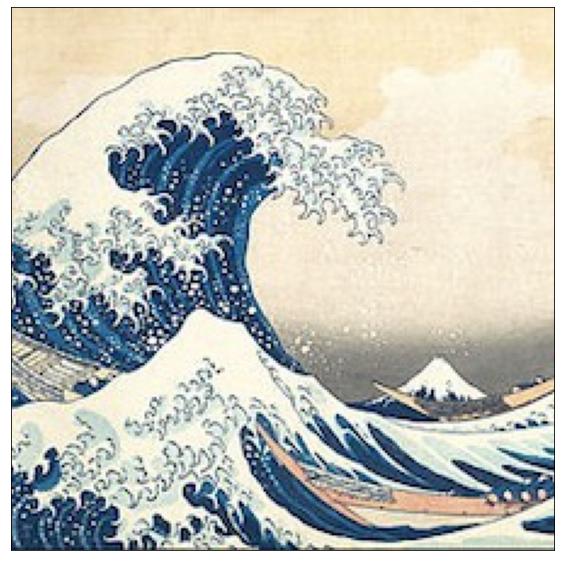

In [27]:
img = load_and_process("/kaggle/input/neural-style-transfer-test-images/style.jpg")
display_image(img)


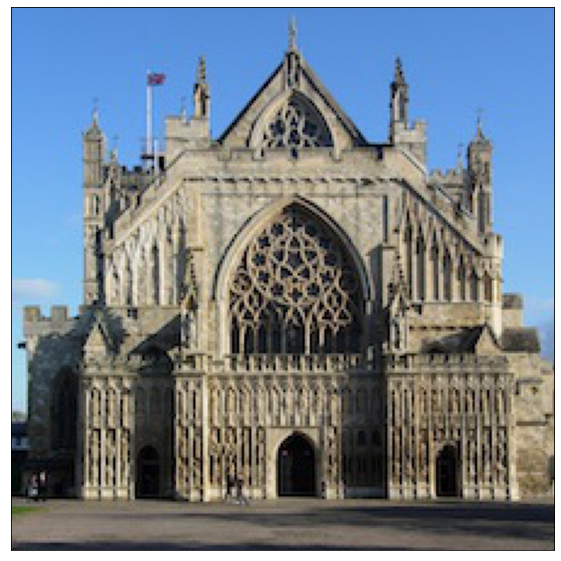

In [28]:
img = load_and_process("/kaggle/input/neural-style-transfer-test-images/content.jpg")
display_image(img)


In [10]:
style_layers = [
    'block1_conv1', 
    'block3_conv1', 
    'block5_conv1'
]

content_layer = 'block5_conv2'

content_model  = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(
    inputs = model.input,
    outputs = model.get_layer(layer).output) for layer in style_layers]

In [11]:
def content_cost(content,generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

In [12]:
def gram(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A,[-1,channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a,a,transpose_a = True)
    return gram / tf.cast(n,tf.float32)

In [13]:
weight = 1. / len(style_models)

def style_cost(style,generated):
    J_cost = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        gs = gram(a_S)
        gg = gram(a_G)
        current_cost = tf.reduce_mean(tf.square(gs-gg))
        J_cost += current_cost * weight
    return J_cost

In [24]:
generated_images = []

def training_loop(content_path,style_path,iterations = 20,alpha = 10.,beta = 20.):
    content = load_and_process("/kaggle/input/neural-style-transfer-test-images/content.jpg")
    style = load_and_process("/kaggle/input/neural-style-transfer-test-images/style.jpg")
    generated = tf.Variable(content,dtype = tf.float32)
    
    
    opt = tf.optimizers.Adam(learning_rate = 7.)
    
    best_cost = 1e12 + 0.1
    best_image = None
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content,generated)
            J_style = style_cost(style,generated)
            J_total = alpha*J_content + beta*J_style
                
            
        grads = tape.gradient(J_total,generated)
        opt.apply_gradients([(grads,generated)])
        
        if J_total<best_cost:
            best_cost = J_total
            best_image = generated.numpy()
            
        if i % int(iterations/10) == 0:
            
            print('Cost at {}: {}. '.format(i, J_total))
            generated_images.append(generated.numpy())
        
    return best_image

In [25]:
final = training_loop("/kaggle/input/images-for-style-transfer/Data/TestCases/37864.jpg","/kaggle/input/images-for-style-transfer/data/Data/Artworks/86092.jpg")

Cost at 0: 13733986304.0. 
Cost at 5: 2790091264.0. 
Cost at 10: 1640953344.0. 
Cost at 15: 1021777216.0. 
Cost at 20: 738897280.0. 
Cost at 25: 557096576.0. 
Cost at 30: 442771520.0. 
Cost at 35: 366205888.0. 
Cost at 40: 310532192.0. 
Cost at 45: 270751552.0. 


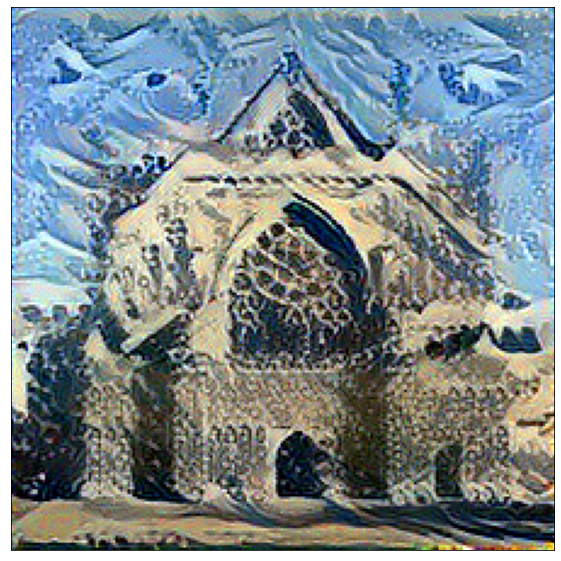

In [26]:
display_image(final)